Connected to .venv (3.11.8) (Python 3.11.8)

 # Part 1: Setup and Data Preparation

In [ ]:
# --- Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import xgboost as xgb

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, make_scorer, recall_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# --- Data Loading and Initial Inspection ---
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

print("--- Initial Data Info ---")
print(df.info())
print("\n--- Missing Values ---")
print(df.isnull().sum())
print("\n--- First 5 Rows ---")
print(df.head())

--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               2536

In [ ]:
# --- Target Variable Preprocessing and Splitting ---
print("\n--- Class Distribution ---")
print(df['Diabetes_012'].value_counts())

df.rename(columns={'Diabetes_012': 'class'}, inplace=True)

X = df.drop('class', axis=1)
y = df['class']

# Stratified split for train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Stratified split for train/validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


--- Class Distribution ---
Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64

Training set shape: (162355, 21)
Validation set shape: (40589, 21)
Test set shape: (50736, 21)


 # Part 2: Exploratory Data Analysis (EDA)

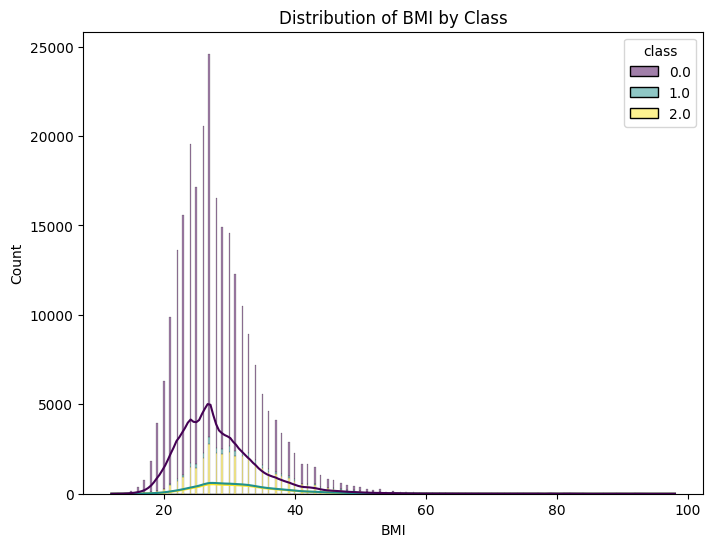

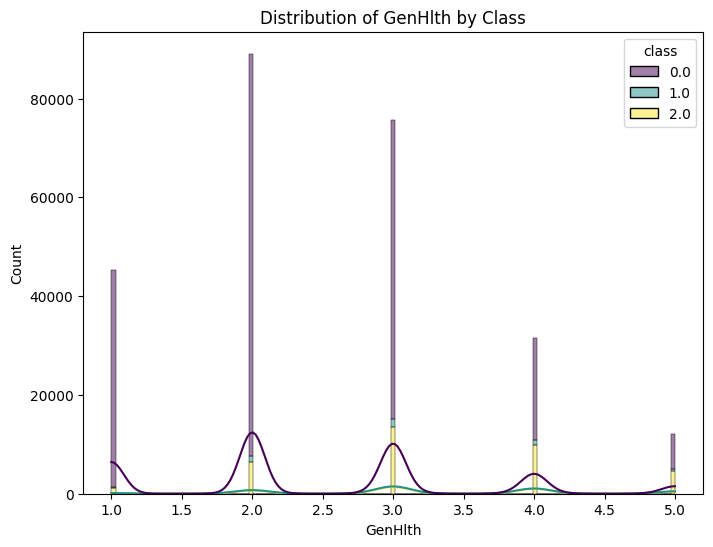

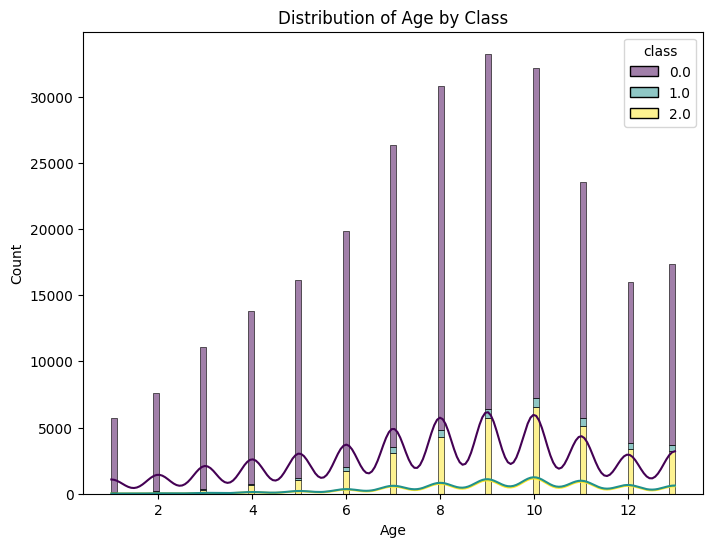

In [ ]:
# --- Histograms for Key Features ---
for col in ['BMI', 'GenHlth', 'Age']:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=col, hue='class', kde=True, multiple="stack", palette="viridis")
    plt.title(f'Distribution of {col} by Class')
    plt.show()

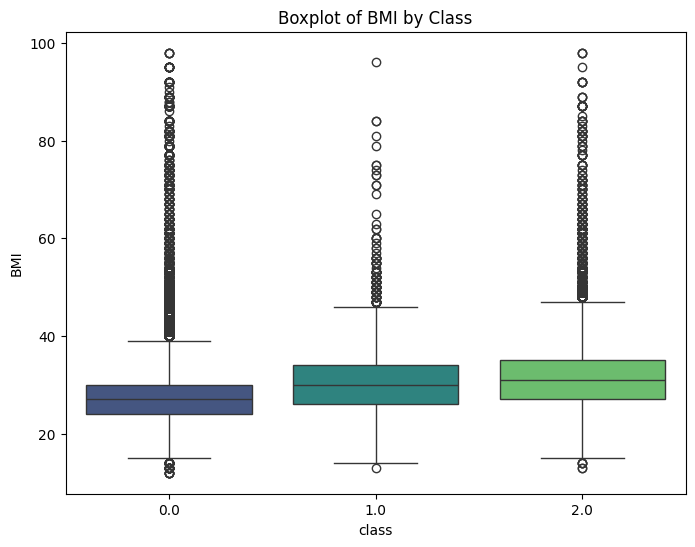

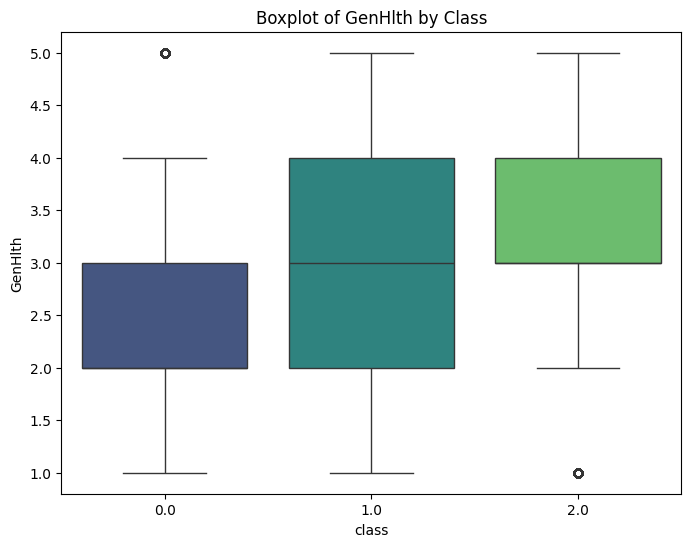

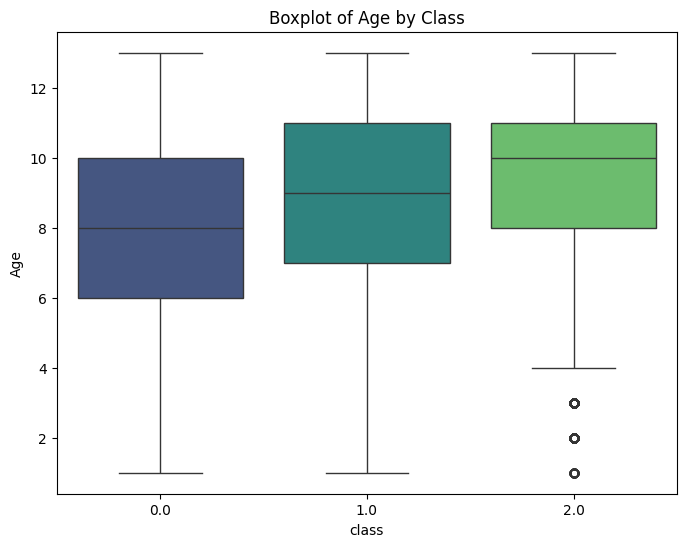

In [ ]:
# --- Box Plots for Key Features ---
for col in ['BMI', 'GenHlth', 'Age']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='class', y=col, data=df, palette="viridis")
    plt.title(f'Boxplot of {col} by Class')
    plt.show()

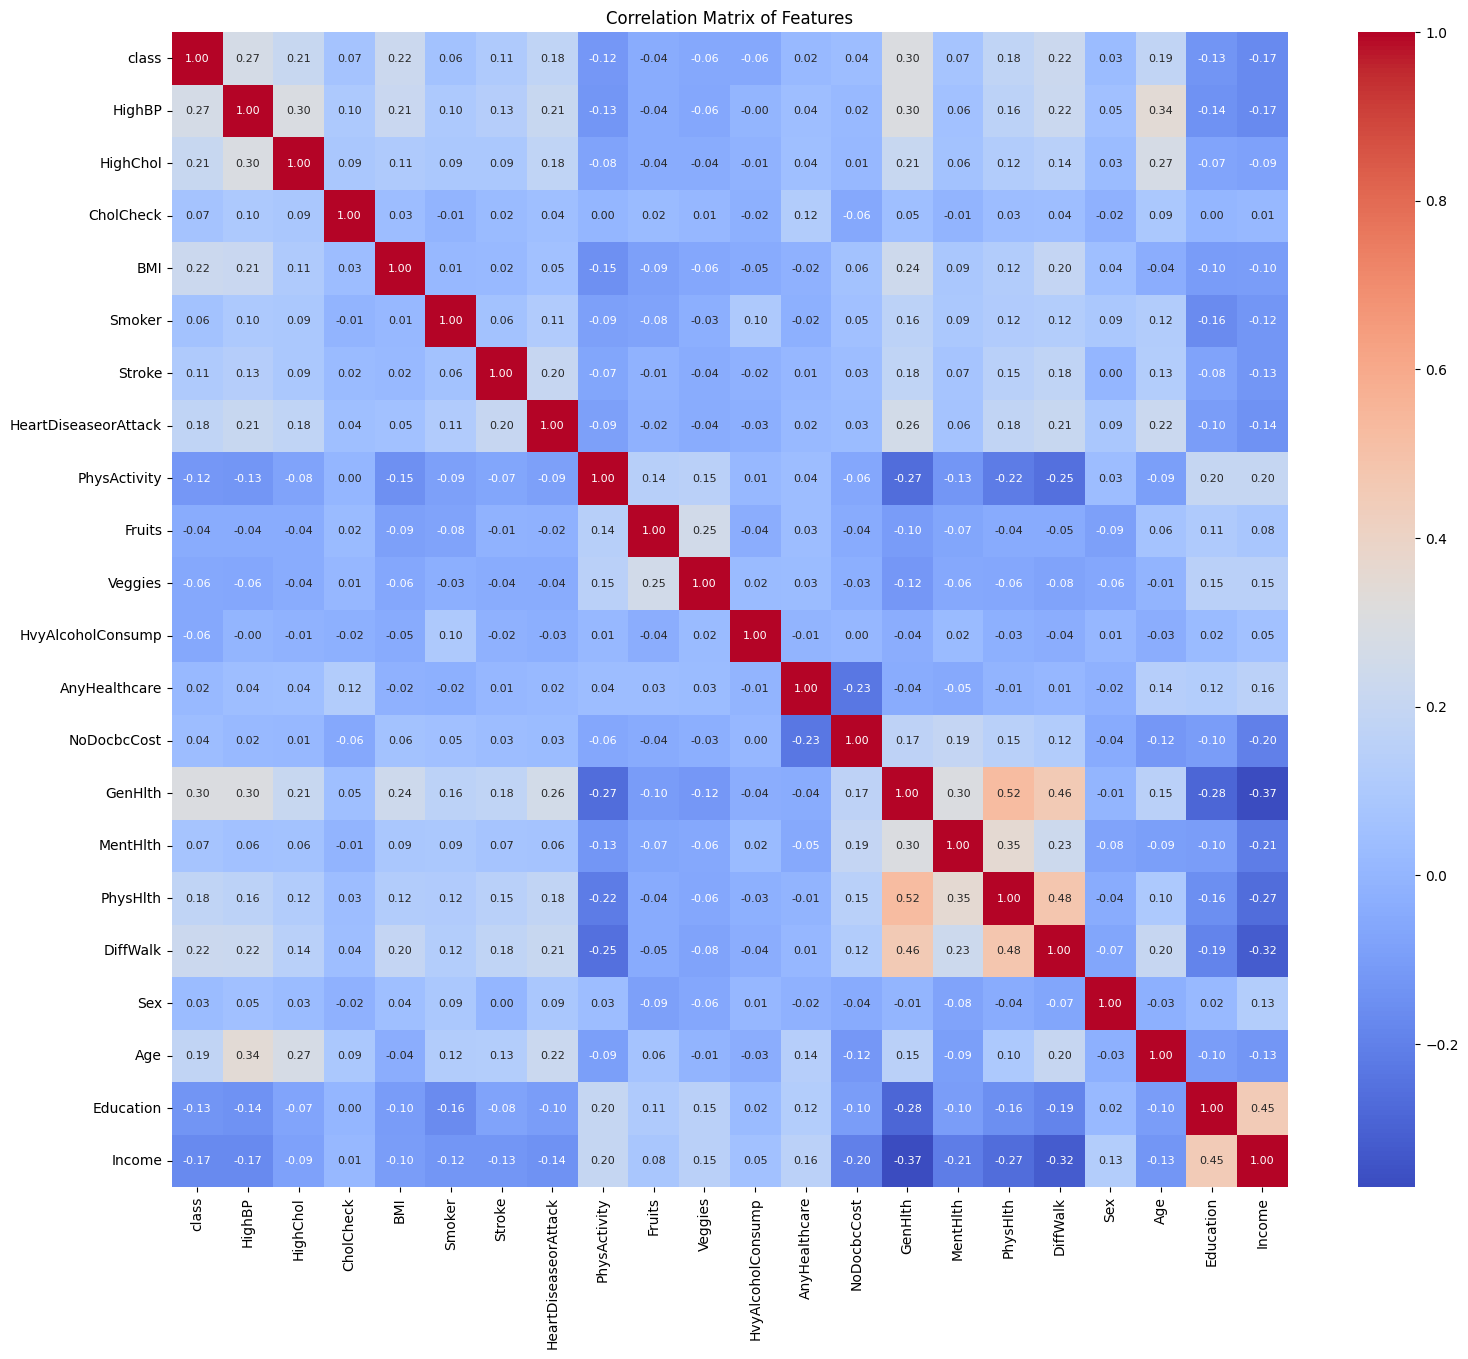

In [ ]:
# --- Correlation Matrix ---
plt.figure(figsize=(18, 15))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
# --- Feature Importance Assessment ---
# Chi-Square Scores
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_train, y_train)
chi2_scores = pd.Series(chi2_selector.scores_, index=X_train.columns)
print("\n--- Chi-Square Scores ---")
print(chi2_scores.sort_values(ascending=False))

# F-value Scores
fvalue_selector = SelectKBest(f_classif, k='all')
fvalue_selector.fit(X_train, y_train)
fvalue_scores = pd.Series(fvalue_selector.scores_, index=X_train.columns)
print("\n--- F-value Scores ---")
print(fvalue_scores.sort_values(ascending=False))


--- Chi-Square Scores ---
PhysHlth                92635.798182
MentHlth                15894.387924
BMI                     12876.476309
HighBP                   6926.869689
DiffWalk                 6896.337480
GenHlth                  6893.944889
Age                      6598.169682
HeartDiseaseorAttack     4841.642911
HighChol                 4173.975021
Income                   3468.824993
Stroke                   1769.635496
PhysActivity              613.030454
Education                 543.454121
HvyAlcoholConsump         520.310325
Smoker                    378.664856
NoDocbcCost               234.716730
Fruits                    109.589039
Veggies                   101.232093
Sex                        97.156542
CholCheck                  29.087715
AnyHealthcare               2.250264
dtype: float64

--- F-value Scores ---
GenHlth                 8352.437479
HighBP                  6550.116143
BMI                     4401.596424
DiffWalk                4374.744602
HighChol     

 # Part 3: Sklearn Modeling Pipelines

In [ ]:
# --- Define Preprocessing, Feature Selection, and SMOTE ---
numeric_features = X.columns.tolist()
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)])

smote = SMOTE(random_state=42)
feature_selector = SelectKBest(chi2)

# --- Define Model Pipelines ---
# Logistic Regression Pipeline
pipeline_lr = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('feature_selection', SelectKBest(chi2)),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'))
])

# Random Forest Pipeline
pipeline_rf = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('feature_selection', SelectKBest(chi2)),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# XGBoost Pipeline
pipeline_xgb = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('feature_selection', SelectKBest(chi2)),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])

 # Part 4: Hyperparameter Tuning

In [ ]:
# --- Tuning Function ---
def tune_model(pipeline, param_grid, X_train, y_train, n_iter=10):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    recall_scorer = make_scorer(recall_score, average='macro')

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        cv=kfold,
        scoring=recall_scorer,
        verbose=1,
        n_jobs=-1,
        n_iter=n_iter,
        random_state=42,
        error_score=0
    )
    search.fit(X_train, y_train)
    print(f"Best parameters: {search.best_params_}")
    print(f"Best cross-validation score (macro recall): {search.best_score_:.4f}")
    return search.best_estimator_

# --- Hyperparameter Grids ---
param_grid_lr = {
    'feature_selection__k': [7, 10, 15, 'all'],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

param_grid_rf = {
    'feature_selection__k': [7, 10, 15, 'all'],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'feature_selection__k': [7, 10, 15, 'all'],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

In [ ]:
# --- Tune Models (Using smaller n_iter for speed) ---
print("--- Tuning Logistic Regression ---")
best_lr = tune_model(pipeline_lr, param_grid_lr, X_train, y_train, n_iter=4)

print("\n--- Tuning Random Forest ---")
best_rf = tune_model(pipeline_rf, param_grid_rf, X_train, y_train, n_iter=4)

print("\n--- Tuning XGBoost ---")
best_xgb = tune_model(pipeline_xgb, param_grid_xgb, X_train, y_train, n_iter=4)

--- Tuning Logistic Regression ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'feature_selection__k': 'all', 'classifier__penalty': 'l2', 'classifier__C': 0.1}
Best cross-validation score (macro recall): 0.5138

--- Tuning Random Forest ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'feature_selection__k': 'all', 'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__max_depth': 5}
Best cross-validation score (macro recall): 0.4990

--- Tuning XGBoost ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/nikitakumari/Downloads/Project/Diabetes/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nikitakumari/Downloads/Project/Diabetes/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nikitakumari/Downloads/Project/Diabetes/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nikitakumari/Downloads/Project/Diabetes/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:03:

Best parameters: {'feature_selection__k': 15, 'classifier__n_estimators': 200, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
Best cross-validation score (macro recall): 0.5019


 # Part 5: PyTorch MLP Implementation

In [ ]:
# --- PyTorch Dataset Class ---
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- Preprocess data and apply SMOTE for PyTorch ---
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

train_dataset = DiabetesDataset(X_train_resampled, y_train_resampled)
val_dataset = DiabetesDataset(X_val_processed, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
# --- MLP Model Architecture ---
class MLP(nn.Module):
    def __init__(self, input_size, num_classes=3):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

# --- Training Loop ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(X_train_resampled.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

epochs = 10
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # --- Validation Loop ---
    model.eval()
    with torch.no_grad():
        val_losses = []
        all_preds, all_labels, all_probs = [], [], []
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())

            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {np.mean(val_losses):.4f}')

Epoch 1/10, Training Loss: 0.8625, Validation Loss: 0.8389
Epoch 2/10, Training Loss: 0.5741, Validation Loss: 0.8581
Epoch 3/10, Training Loss: 0.9703, Validation Loss: 0.8355
Epoch 4/10, Training Loss: 0.4644, Validation Loss: 0.8401
Epoch 5/10, Training Loss: 1.2647, Validation Loss: 0.8078
Epoch 6/10, Training Loss: 0.9076, Validation Loss: 0.8018
Epoch 7/10, Training Loss: 0.6180, Validation Loss: 0.7712
Epoch 8/10, Training Loss: 0.4664, Validation Loss: 0.7895
Epoch 9/10, Training Loss: 0.5041, Validation Loss: 0.8296
Epoch 10/10, Training Loss: 0.7682, Validation Loss: 0.7834



--- PyTorch MLP Validation Report ---
              precision    recall  f1-score   support

           0       0.94      0.65      0.77     34193
           1       0.03      0.26      0.05       741
           2       0.33      0.57      0.41      5655

    accuracy                           0.63     40589
   macro avg       0.43      0.49      0.41     40589
weighted avg       0.84      0.63      0.71     40589

ROC AUC (One-vs-Rest): 0.7342


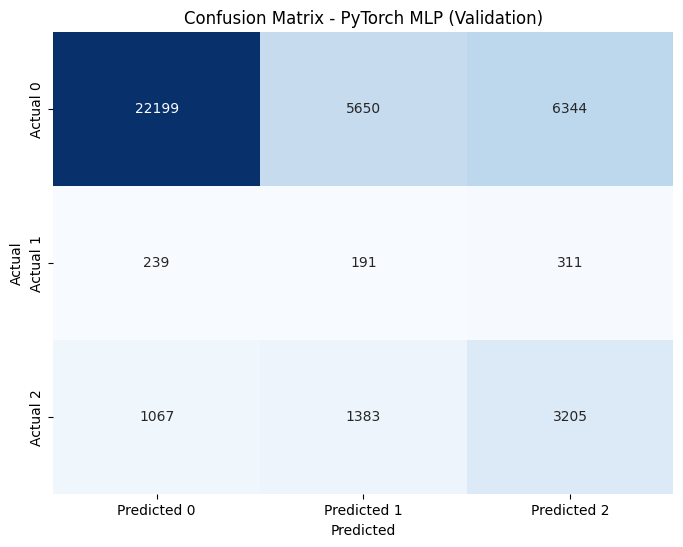

In [ ]:
# --- Evaluate PyTorch MLP ---
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

print("\n--- PyTorch MLP Validation Report ---")
print(classification_report(all_labels, all_preds))
print(f"ROC AUC (One-vs-Rest): {roc_auc_score(all_labels, all_probs, multi_class='ovr'):.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2'],
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - PyTorch MLP (Validation)')
plt.show()

 # Part 6: Final Model Evaluation on Test Set

In [ ]:
# --- Evaluation Function ---
def evaluate_pipeline(pipeline, X_test, y_test, title):
    print(f"\n--- {title} ---")
    y_pred = pipeline.predict(X_test)
    y_probs = pipeline.predict_proba(X_test)

    print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Prediabetes', 'Diabetes']))
    try:
        roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr')
        print(f"ROC AUC (One-vs-Rest): {roc_auc:.4f}")
    except ValueError:
        print("ROC AUC not calculated.")

In [ ]:
# --- Evaluate Best Models on Test Data ---
print("\n--- FINAL TEST SET EVALUATION ---")
evaluate_pipeline(best_lr, X_test, y_test, "Best Logistic Regression on Test Set")
evaluate_pipeline(best_rf, X_test, y_test, "Best Random Forest on Test Set")
evaluate_pipeline(best_xgb, X_test, y_test, "Best XGBoost on Test Set")


--- FINAL TEST SET EVALUATION ---

--- Best Logistic Regression on Test Set ---
              precision    recall  f1-score   support

 No Diabetes       0.95      0.68      0.79     42741
 Prediabetes       0.03      0.28      0.06       926
    Diabetes       0.35      0.59      0.44      7069

    accuracy                           0.66     50736
   macro avg       0.44      0.52      0.43     50736
weighted avg       0.85      0.66      0.73     50736

ROC AUC (One-vs-Rest): 0.7684

--- Best Random Forest on Test Set ---
              precision    recall  f1-score   support

 No Diabetes       0.93      0.76      0.83     42741
 Prediabetes       0.03      0.11      0.05       926
    Diabetes       0.34      0.63      0.44      7069

    accuracy                           0.73     50736
   macro avg       0.43      0.50      0.44     50736
weighted avg       0.83      0.73      0.76     50736

ROC AUC (One-vs-Rest): 0.7693

--- Best XGBoost on Test Set ---
              precision